<a href="https://colab.research.google.com/github/DRepresser/NeuroClassify/blob/main/ESM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## setup colab

In [4]:
!pip install -q fair-esm catboost
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python -q rapidsai-csp-utils/colab/pip-install.py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 22.8 MB/s eta 0:00:00
Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 553, done.
remote: Counting objects: 100% (284/284), done.
remote: Compressing objects: 100% (182/182), done.
remote: Total 553 (delta 179), reused 147 (delta 100), pack-reused 269 (from 1)
Receiving objects: 100% (553/553), 178.44 KiB | 4.70 MiB/s, done.
Resolving deltas: 100% (281/281), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 3.3 MB/s eta 0:00:00
Installing RAPIDS remaining 24.10.* libraries
Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 567.7/567.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 GB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 81.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from scipy.stats import spearmanr
from sklearn.model_selection import ParameterGrid, GridSearchCV, train_test_split, cross_val_score
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, PassiveAggressiveClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    r2_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
from sklearn.model_selection import KFold

from cuml.svm import SVC as CumlSVC

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

import esm
import gc

## Model

In [ ]:
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
batch_converter = alphabet.get_batch_converter()

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt


In [ ]:
model

ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0-32): 33 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=660, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (emb_layer_norm_after): LayerNorm((1280,), eps=1

## Extract features using ESM

In [6]:
file_path = "/content/drive/MyDrive/ESM/data_clean/downsampled_and_concat.csv"
df = pd.read_csv(file_path)
df = df.drop(columns=['length'])
df

,sequence,label
0,VEPKDLARRIFLAGSKSKTSVLDSEENEKFLYCDKG,0
1,AGPDPIEEDDPLWGMVKDVCCLLMNQLKSAEQKG,0
2,GNPDGCSSASSRAGQARRERGNQG,1
3,TRRCPRY,0
4,EEDPRVRYSAQLTYGLSPITVNPLD,0
...,...,...
99995,QPRSQRLARENSYESYTSRSTTSDYSTGSEG,1
99996,CSPILRFSPYNQLKQRQAQDKLGPI,0
99997,PVLRPHHCHVVVVRLHPCHPVCRAPPVRCPCVCP,0
99998,GDHQNIQGSGLWGSGGTWVGYAGGPKDKTKAKK,1


In [ ]:
def extract_esm_features(df, batch_size=64):
    """
    Extract ESM embeddings for a dataset.

    Parameters:
    - df: DataFrame with a column for sequences.
    - batch_size: Number of sequences to process per batch.

    Returns:
    - A NumPy array containing embeddings for each sequence.
    """
    all_embeddings = []

    for i in tqdm(range(0, len(df), batch_size)):
        batch_sequences = df.iloc[i:i+batch_size]
        data = [(str(index), row['sequence']) for index, row in batch_sequences.iterrows()]
        batch_labels, batch_strs, batch_tokens = batch_converter(data)

        batch_tokens = batch_tokens.to(device)

        with torch.no_grad():
            results = model(batch_tokens, repr_layers=[33])
            token_embeddings = results["representations"][33]

        for j, (_, seq) in enumerate(data):
            embedding = token_embeddings[j, 1 : len(seq) + 1].mean(0).cpu().numpy()
            all_embeddings.append(embedding)

        del batch_tokens, results, token_embeddings
        torch.cuda.empty_cache()
        gc.collect()

    return np.array(all_embeddings)

In [ ]:
df_features = extract_esm_features(df)

100%|██████████| 1563/1563 [14:07<00:00,  1.84it/s]


In [ ]:
output_path = "/content/drive/MyDrive/ESM/data_feature_extract"
np.save(output_path + "feature_extract.npy", df_features)

## PCA

In [7]:
dataset_path = "/content/drive/MyDrive/ESM/data_feature_extract"
df_features = np.load(dataset_path + "feature_extract.npy")

In [8]:
pca = PCA(n_components=128)
train_reduced_features = pca.fit_transform(df_features)

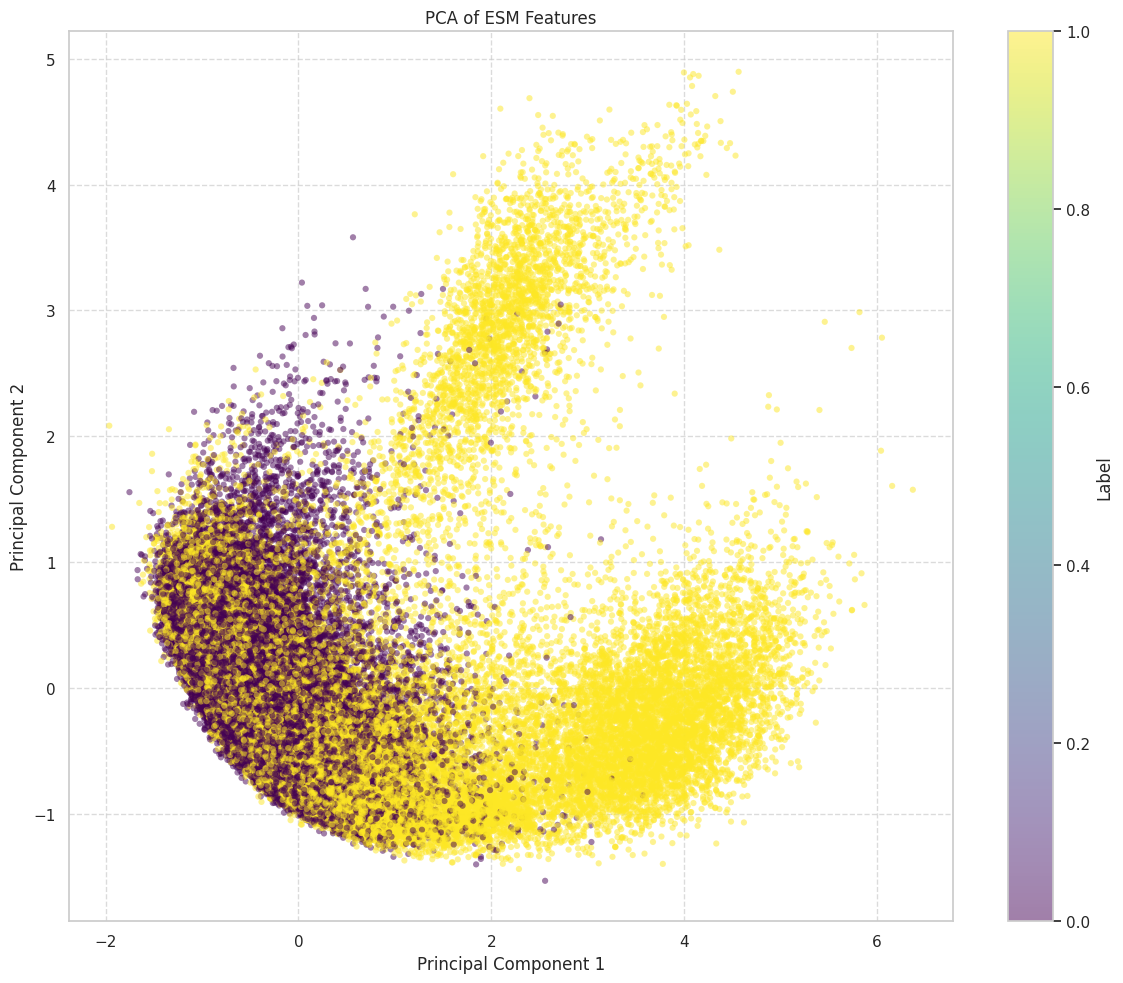

In [10]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 10))

scatter = plt.scatter(
    train_reduced_features[:, 0],
    train_reduced_features[:, 1],
    c=df['label'],
    cmap='viridis',
    s=20,
    alpha=0.5,
    edgecolor='none'
)

plt.title("PCA of ESM Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

cbar = plt.colorbar(scatter)
cbar.set_label('Label')

plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
sns.set(style="whitegrid")
n_components = 20
fig, axes = plt.subplots(n_components - 1, n_components - 1, figsize=(100, 100), sharex='col', sharey='row')

for i in range(1, n_components):
    for j in range(n_components - 1):
        ax = axes[i - 1, j]
        if j < i:
            scatter = ax.scatter(
                train_reduced_features[:, j],
                train_reduced_features[:, i],
                c=df['label'],
                cmap='viridis',
                s=5,
                alpha=0.5,
                edgecolor='none'
            )
            ax.set_xlabel(f"PC {j + 1}")
            ax.set_ylabel(f"PC {i + 1}")
            ax.grid(True, linestyle='--', alpha=0.7)
        else:
            ax.axis('off')


plt.tight_layout()
plt.show()

## Train

In [ ]:
def perform_cross_validated_training(models, features, labels, n_splits=5):
    """
    Train and evaluate classification models with cross-validation.

    Args:
        models (list): List of initialized classification models.
        features (pd.DataFrame or np.ndarray): Feature set.
        labels (pd.Series or np.ndarray): Label set.
        n_splits (int): Number of cross-validation splits.

    Returns:
        pd.DataFrame: DataFrame summarizing model performance.
    """
    results = []

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for model in tqdm(models, desc="Training models"):
        tqdm.write(f"Evaluating: {model.__class__.__name__}")

        accuracies, precisions, recalls, f1_scores, conf_matrices = [], [], [], [], []

        for train_idx, test_idx in kf.split(features):
            train_features, test_features = features[train_idx], features[test_idx]
            train_labels, test_labels = labels[train_idx], labels[test_idx]

            model.fit(train_features, train_labels)

            test_preds = model.predict(test_features)

            accuracies.append(accuracy_score(test_labels, test_preds))
            precisions.append(precision_score(test_labels, test_preds, average='weighted', zero_division=0))
            recalls.append(recall_score(test_labels, test_preds, average='weighted', zero_division=0))
            f1_scores.append(f1_score(test_labels, test_preds, average='weighted', zero_division=0))

            conf_matrix = confusion_matrix(test_labels, test_preds)
            conf_matrices.append(conf_matrix)

        args = {
            "Model": model.__class__.__name__,
            "Accuracy": np.mean(accuracies),
            "Precision": np.mean(precisions),
            "Recall": np.mean(recalls),
            "F1 Score": np.mean(f1_scores),
            "Confusion Matrix": np.sum(conf_matrices, axis=0).tolist()
        }
        print(args)
        results.append(args)

    results_df = pd.DataFrame(results)
    return results_df

In [ ]:
classification_models = [
    # Linear Models
    LogisticRegression(max_iter=1000),
    RidgeClassifier(),
    PassiveAggressiveClassifier(),

    # GPU-accelerated SVM
    CumlSVC(probability=True),

    # Tree-Based Models
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    ExtraTreesClassifier(),
    GradientBoostingClassifier(),
    AdaBoostClassifier(),

    # Ensemble Models
    BaggingClassifier(),

    # K-Nearest Neighbors
    KNeighborsClassifier(),

    # Neural Networks
    MLPClassifier(max_iter=1000),

    # Bayesian Models
    BernoulliNB(),

    # Discriminant Analysis
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),

    # Gradient Boosting Libraries
    XGBClassifier(eval_metric='logloss', use_label_encoder=False),
    LGBMClassifier(),
    CatBoostClassifier(verbose=0)
]

In [ ]:
features = train_reduced_features.values if isinstance(train_reduced_features, pd.DataFrame) else train_reduced_features
labels = df['label'].values if isinstance(df['label'], pd.Series) else df['label']

results_df = perform_cross_validated_training(
    classification_models, features, df['label']
)



Training models:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating: LogisticRegression




Training models:   6%|▌         | 1/18 [00:03<01:05,  3.86s/it]

{'Model': 'LogisticRegression', 'Accuracy': 0.69588, 'Precision': 0.70047393693647, 'Recall': 0.69588, 'F1 Score': 0.6941474662338367, 'Confusion Matrix': [[38562, 11438], [18974, 31026]]}
Evaluating: RidgeClassifier




Training models:  11%|█         | 2/18 [00:04<00:34,  2.17s/it]

{'Model': 'RidgeClassifier', 'Accuracy': 0.69454, 'Precision': 0.7020780208609132, 'Recall': 0.69454, 'F1 Score': 0.6916846379757338, 'Confusion Matrix': [[39542, 10458], [20088, 29912]]}
Evaluating: PassiveAggressiveClassifier




Training models:  17%|█▋        | 3/18 [00:07<00:38,  2.54s/it]

{'Model': 'PassiveAggressiveClassifier', 'Accuracy': 0.61564, 'Precision': 0.6242922287815662, 'Recall': 0.61564, 'F1 Score': 0.6075622663509858, 'Confusion Matrix': [[26338, 23662], [14774, 35226]]}
Evaluating: SVC




Training models:  22%|██▏       | 4/18 [01:02<05:23, 23.13s/it]

{'Model': 'SVC', 'Accuracy': 0.71307, 'Precision': 0.7145440596209012, 'Recall': 0.71307, 'F1 Score': 0.7125972659251233, 'Confusion Matrix': [[37687, 12313], [16380, 33620]]}
Evaluating: DecisionTreeClassifier




Training models:  28%|██▊       | 5/18 [03:12<13:21, 61.68s/it]

{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.61521, 'Precision': 0.6152767637149049, 'Recall': 0.61521, 'F1 Score': 0.6151969301305783, 'Confusion Matrix': [[30463, 19537], [18942, 31058]]}
Evaluating: RandomForestClassifier




Training models:  33%|███▎      | 6/18 [17:27<1:06:15, 331.26s/it]

{'Model': 'RandomForestClassifier', 'Accuracy': 0.6854600000000001, 'Precision': 0.6976003259563536, 'Recall': 0.6854600000000001, 'F1 Score': 0.6805771797061635, 'Confusion Matrix': [[40456, 9544], [21910, 28090]]}
Evaluating: ExtraTreesClassifier




Training models:  39%|███▉      | 7/18 [19:46<49:14, 268.60s/it]

{'Model': 'ExtraTreesClassifier', 'Accuracy': 0.68353, 'Precision': 0.6986007622451046, 'Recall': 0.68353, 'F1 Score': 0.6774312834815287, 'Confusion Matrix': [[41053, 8947], [22700, 27300]]}
Evaluating: GradientBoostingClassifier




Training models:  44%|████▍     | 8/18 [1:01:53<2:44:35, 987.59s/it]

{'Model': 'GradientBoostingClassifier', 'Accuracy': 0.6872499999999999, 'Precision': 0.7032591849633882, 'Recall': 0.6872499999999999, 'F1 Score': 0.6810003073420956, 'Confusion Matrix': [[41362, 8638], [22637, 27363]]}
Evaluating: AdaBoostClassifier


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.6674100000000001, 'Precision': 0.6718734266358071, 'Recall': 0.6674100000000001, 'F1 Score': 0.6652592594994655, 'Confusion Matrix': [[37377, 12623], [20636, 29364]]}
Evaluating: BaggingClassifier




Training models:  56%|█████▌    | 10/18 [1:23:44<1:50:45, 830.66s/it]

{'Model': 'BaggingClassifier', 'Accuracy': 0.65779, 'Precision': 0.66728530394966, 'Recall': 0.65779, 'F1 Score': 0.652881435542963, 'Confusion Matrix': [[38836, 11164], [23057, 26943]]}
Evaluating: KNeighborsClassifier




Training models:  61%|██████    | 11/18 [1:24:07<1:08:04, 583.47s/it]

{'Model': 'KNeighborsClassifier', 'Accuracy': 0.6548299999999999, 'Precision': 0.6559670549807076, 'Recall': 0.6548299999999999, 'F1 Score': 0.6542222371506139, 'Confusion Matrix': [[34843, 15157], [19360, 30640]]}
Evaluating: MLPClassifier




Training models:  67%|██████▋   | 12/18 [1:41:18<1:11:57, 719.57s/it]

{'Model': 'MLPClassifier', 'Accuracy': 0.67893, 'Precision': 0.6794972760952082, 'Recall': 0.67893, 'F1 Score': 0.6787556971290798, 'Confusion Matrix': [[34344, 15656], [16451, 33549]]}
Evaluating: BernoulliNB




Training models:  72%|███████▏  | 13/18 [1:41:19<41:50, 502.09s/it]

{'Model': 'BernoulliNB', 'Accuracy': 0.65981, 'Precision': 0.6608433332416161, 'Recall': 0.65981, 'F1 Score': 0.6592863314468641, 'Confusion Matrix': [[34955, 15045], [18974, 31026]]}
Evaluating: LinearDiscriminantAnalysis




Training models:  78%|███████▊  | 14/18 [1:41:23<23:25, 351.40s/it]

{'Model': 'LinearDiscriminantAnalysis', 'Accuracy': 0.69454, 'Precision': 0.7020335420816978, 'Recall': 0.69454, 'F1 Score': 0.6917013122410636, 'Confusion Matrix': [[39528, 10472], [20074, 29926]]}
Evaluating: QuadraticDiscriminantAnalysis




Training models:  83%|████████▎ | 15/18 [1:41:27<12:20, 246.78s/it]

{'Model': 'QuadraticDiscriminantAnalysis', 'Accuracy': 0.64663, 'Precision': 0.7038588185145288, 'Recall': 0.64663, 'F1 Score': 0.619940407186224, 'Confusion Matrix': [[45578, 4422], [30915, 19085]]}
Evaluating: XGBClassifier


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:15:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:15:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:15:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:15:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:15:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

{'Model': 'XGBClassifier', 'Accuracy': 0.6933499999999999, 'Precision': 0.6953901147387441, 'Recall': 0.6933499999999999, 'F1 Score': 0.6925699259467869, 'Confusion Matrix': [[37193, 12807], [17858, 32142]]}
Evaluating: LGBMClassifier
[LightGBM] [Info] Number of positive: 40078, number of negative: 39922
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32640
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 128
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500975 -> initscore=0.003900
[LightGBM] [Info] Start training from score 0.003900
[LightGBM] [Info] Number of positive: 40049, number of negative: 39951
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32640
[Li



Training models:  94%|█████████▍| 17/18 [1:41:58<02:08, 128.35s/it]

{'Model': 'LGBMClassifier', 'Accuracy': 0.69825, 'Precision': 0.7048747455460955, 'Recall': 0.69825, 'F1 Score': 0.6958241923308993, 'Confusion Matrix': [[39380, 10620], [19555, 30445]]}
Evaluating: CatBoostClassifier



Training models: 100%|██████████| 18/18 [1:43:38<00:00, 345.47s/it]

{'Model': 'CatBoostClassifier', 'Accuracy': 0.7062999999999999, 'Precision': 0.709695532050285, 'Recall': 0.7062999999999999, 'F1 Score': 0.7051216651355313, 'Confusion Matrix': [[38481, 11519], [17851, 32149]]}


In [ ]:
results_df

,Model,Accuracy,Precision,Recall,F1 Score,Confusion Matrix
0,LogisticRegression,0.69588,0.700474,0.69588,0.694147,"[[38562, 11438], [18974, 31026]]"
1,RidgeClassifier,0.69454,0.702078,0.69454,0.691685,"[[39542, 10458], [20088, 29912]]"
2,PassiveAggressiveClassifier,0.61564,0.624292,0.61564,0.607562,"[[26338, 23662], [14774, 35226]]"
3,SVC,0.71307,0.714544,0.71307,0.712597,"[[37687, 12313], [16380, 33620]]"
4,DecisionTreeClassifier,0.61521,0.615277,0.61521,0.615197,"[[30463, 19537], [18942, 31058]]"
5,RandomForestClassifier,0.68546,0.697600,0.68546,0.680577,"[[40456, 9544], [21910, 28090]]"
6,ExtraTreesClassifier,0.68353,0.698601,0.68353,0.677431,"[[41053, 8947], [22700, 27300]]"
7,GradientBoostingClassifier,0.68725,0.703259,0.68725,0.681000,"[[41362, 8638], [22637, 27363]]"
8,AdaBoostClassifier,0.66741,0.671873,0.66741,0.665259,"[[37377, 12623], [20636, 29364]]"
9,BaggingClassifier,0.65779,0.667285,0.65779,0.652881,"[[38836, 11164], [23057, 26943]]"


In [ ]:
results_df.to_csv('/content/drive/MyDrive/ESM/results.csv', index=False)

## Grid search

In [ ]:
features = train_reduced_features.values if isinstance(train_reduced_features, pd.DataFrame) else train_reduced_features
labels = df['label'].values if isinstance(df['label'], pd.Series) else df['label']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [ ]:
classification_models = [
    ('LogisticRegression', LogisticRegression(max_iter=1000), {'C': [0.1, 1, 10]}),
    ('RidgeClassifier', RidgeClassifier(), {'alpha': [0.1, 1, 10]}),
    ('PassiveAggressiveClassifier', PassiveAggressiveClassifier(), {'C': [0.1, 1, 10]}),
    ('CumlSVC', CumlSVC(probability=True), {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}),
    ('DecisionTreeClassifier', DecisionTreeClassifier(), {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5]}),
    ('RandomForestClassifier', RandomForestClassifier(), {'n_estimators': [50, 100], 'max_depth': [None, 10]}),
    ('ExtraTreesClassifier', ExtraTreesClassifier(), {'n_estimators': [50, 100], 'max_depth': [None, 10]}),
    ('GradientBoostingClassifier', GradientBoostingClassifier(), {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}),
    ('AdaBoostClassifier', AdaBoostClassifier(), {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}),
    ('BaggingClassifier', BaggingClassifier(), {'n_estimators': [10, 20]}),
    ('KNeighborsClassifier', KNeighborsClassifier(), {'n_neighbors': [3, 5, 7]}),
    ('MLPClassifier', MLPClassifier(max_iter=1000), {'hidden_layer_sizes': [(100,), (50, 50)], 'alpha': [0.0001, 0.001]}),
    ('BernoulliNB', BernoulliNB(), {'alpha': [0.5, 1]}),
    ('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis(), {'solver': ['svd', 'lsqr']}),
    ('QuadraticDiscriminantAnalysis', QuadraticDiscriminantAnalysis(), {'reg_param': [0.0, 0.1, 0.5]}),
    ('XGBClassifier', XGBClassifier(eval_metric='logloss', use_label_encoder=False), {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}),
    ('LGBMClassifier', LGBMClassifier(), {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}),
    ('CatBoostClassifier', CatBoostClassifier(verbose=0), {'iterations': [50, 100], 'learning_rate': [0.01, 0.1]})
]

In [ ]:
results = []

for name, model, param_grid in classification_models:
    print(f"\nGrid search for {name}")
    try:
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            scoring='accuracy',
            cv=5,
            verbose=1
        )
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_cv_score = grid_search.best_score_

        y_pred = best_model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted')
        conf_matrix = confusion_matrix(y_test, y_pred).flatten().tolist()

        results.append({
            'Model': name,
            'Best Parameters': best_params,
            'Best CV Score': best_cv_score,
            'Test Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'Confusion Matrix': conf_matrix
        })
        print(f"Best params for {name}: {best_params}")
    except Exception as e:
        print(f"Failed grid search for {name}: {str(e)}")
        results.append({
            'Model': name,
            'Best Parameters': 'N/A',
            'Best CV Score': 'N/A',
            'Test Accuracy': 'N/A',
            'Precision': 'N/A',
            'Recall': 'N/A',
            'F1 Score': 'N/A',
            'Confusion Matrix': 'N/A'
        })


Grid search for LogisticRegression
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best params for LogisticRegression: {'C': 1}

Grid search for RidgeClassifier
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best params for RidgeClassifier: {'alpha': 0.1}

Grid search for PassiveAggressiveClassifier
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best params for PassiveAggressiveClassifier: {'C': 0.1}

Grid search for CumlSVC
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params for CumlSVC: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

Grid search for DecisionTreeClassifier
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best params for DecisionTreeClassifier: {'max_depth': 10, 'min_samples_split': 2}

Grid search for RandomForestClassifier
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best params for RandomForestClassifier: {'max_depth': None, 'n_estimators': 100}

Grid search for ExtraTreesClassifier
F

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

Best params for AdaBoostClassifier: {'learning_rate': 0.1, 'n_estimators': 100}

Grid search for BaggingClassifier
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best params for BaggingClassifier: {'n_estimators': 20}

Grid search for KNeighborsClassifier
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best params for KNeighborsClassifier: {'n_neighbors': 7}

Grid search for MLPClassifier
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best params for MLPClassifier: {'alpha': 0.0001, 'hidden_layer_sizes': (100,)}

Grid search for BernoulliNB
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best params for BernoulliNB: {'alpha': 0.5}

Grid search for LinearDiscriminantAnalysis
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best params for LinearDiscriminantAnalysis: {'solver': 'svd'}

Grid search for QuadraticDiscriminantAnalysis
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best params for QuadraticDiscriminantA

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:24:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:24:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:24:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:24:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:24:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Best params for XGBClassifier: {'learning_rate': 0.1, 'n_estimators': 100}

Grid search for LGBMClassifier
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Info] Number of positive: 32063, number of negative: 31937
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32640
[LightGBM] [Info] Number of data points in the train set: 64000, number of used features: 128
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500984 -> initscore=0.003938
[LightGBM] [Info] Start training from score 0.003938
[LightGBM] [Info] Number of positive: 32063, number of negative: 31937
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32640
[LightGBM] [Info] Number of data points in the train set: 64000, number

In [ ]:
results_df = pd.DataFrame(results)
results_df

,Model,Best Parameters,Best CV Score,Test Accuracy,Precision,Recall,F1 Score,Confusion Matrix
0,LogisticRegression,{'C': 1},0.697575,0.69155,0.694985,0.69155,0.689885,"[7688, 2390, 3779, 6143]"
1,RidgeClassifier,{'alpha': 0.1},0.696212,0.68830,0.694031,0.68830,0.685589,"[7851, 2227, 4007, 5915]"
2,PassiveAggressiveClassifier,{'C': 0.1},0.671113,0.67040,0.672393,0.67040,0.669697,"[6280, 3798, 2794, 7128]"
3,CumlSVC,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}",0.712250,0.70925,0.709924,0.70925,0.708897,"[7482, 2596, 3219, 6703]"
4,DecisionTreeClassifier,"{'max_depth': 10, 'min_samples_split': 2}",0.646213,0.64395,0.645265,0.64395,0.642817,"[7043, 3035, 4086, 5836]"
5,RandomForestClassifier,"{'max_depth': None, 'n_estimators': 100}",0.687775,0.68340,0.693850,0.68340,0.678537,"[8103, 1975, 4357, 5565]"
6,ExtraTreesClassifier,"{'max_depth': None, 'n_estimators': 100}",0.684513,0.68455,0.698037,0.68455,0.678492,"[8257, 1821, 4488, 5434]"
7,GradientBoostingClassifier,"{'learning_rate': 0.1, 'n_estimators': 100}",0.687075,0.68620,0.699074,0.68620,0.680470,"[8240, 1838, 4438, 5484]"
8,AdaBoostClassifier,"{'learning_rate': 0.1, 'n_estimators': 100}",0.652988,0.65560,0.702477,0.65560,0.633202,"[9064, 1014, 5874, 4048]"
9,BaggingClassifier,{'n_estimators': 20},0.668037,0.66300,0.669866,0.66300,0.659010,"[7751, 2327, 4413, 5509]"


In [ ]:
csv_filename = '/content/drive/MyDrive/ESM/grid_search_results.csv'
results_df.to_csv(csv_filename, index=False)